In [2]:
!which python

/storage/home/itamarreis/.conda/envs/peanuts/bin/python


# Noise in the labels

In [2]:
mkdir results/paper/noise_in_labels

mkdir: cannot create directory ‘results/paper/noise_in_labels’: File exists


In [1]:
from importlib import reload
import numpy
import pickle
import load_data
import noise_data
import PRF
import sklearn
from sklearn.ensemble import RandomForestClassifier

In [6]:
from sklearn.datasets import  make_classification
nof_objects_tot = 200000
nof_features = 15
X, y = make_classification(n_samples=nof_objects_tot, n_classes = 2, class_sep=1, shuffle=True, n_features=nof_features, n_informative=10,
                           random_state=1, n_clusters_per_class=1, flip_y = 0)
dX_orig = numpy.zeros([nof_objects_tot, nof_features])

488.21969951984187

In [13]:
reload(load_data)
reload(noise_data)
n_features = 'auto'
## Train set
n_objs = 5000
noise_in_labels_train = 0
noise_in_features_train = 0
obj_inds = numpy.random.choice(numpy.arange(nof_objects_tot), n_objs*2)
obj_inds_train = obj_inds[::2]
obj_inds_test = obj_inds[1::2]
sigma_mat = noise_data.bad_features_per_object_group_noise(nof_objects_tot, nof_features)
X_tr, dX_tr, y_tr, pY_tr, _  = load_data.get_noised_data(X[obj_inds_train], 
                                                             dX_orig[obj_inds_train], 
                                                             y[obj_inds_train], 
                                                             sigma_mat[obj_inds_train], 
                                                             noise_in_labels_train, 
                                                             noise_in_features_train,
                                                             dist = 'normal')

X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                             dX_orig[obj_inds_test], 
                                                             y[obj_inds_test], 
                                                             sigma_mat[obj_inds_test], 
                                                             noise_in_labels_train, 
                                                             noise_in_features_train,
                                                             dist = 'normal')


noise_in_labels_vec = [0.01,  0.1,  0.2,  0.4,  0.6,  0.8, 1]
n_tress_vec = [1, 10, 25, 50]
for n_trees in n_tress_vec:
    scores_RF = [] 
    scores_PRF = [] 
    fgo_vec = []

    for noise_in_labels in noise_in_labels_vec:
        noise_in_features = 0
        X_tr, dX_tr, y_tr, pY_tr, fgo  = load_data.get_noised_data(X[obj_inds_train], 
                                                                 dX_orig[obj_inds_train], 
                                                                 y[obj_inds_train], 
                                                                 sigma_mat[obj_inds_train], 
                                                                 noise_in_labels, 
                                                                 noise_in_features,
                                                                 dist = 'normal')

        X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                                 dX_orig[obj_inds_test], 
                                                                 y[obj_inds_test], 
                                                                 sigma_mat[obj_inds_test], 
                                                                 0, 
                                                                 noise_in_features,
                                                                 dist = 'normal')
        fgo_vec += [fgo]
        prf = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                            use_py_gini=True, use_py_leafs=True)
        prf.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
        predict, proba = prf.predict(X=X_te, dX=dX_te)
        scores_PRF += [(predict == y_te).sum()/len(predict)]


        rf_sklean = sklearn.ensemble.RandomForestClassifier(n_estimators=n_trees, max_features=n_features, n_jobs = -1)
        rf_sklean.fit(X_tr, y_tr)
        score_RF = rf_sklean.score(X_te, y_te)
        scores_RF += [score_RF]
        print('n_trees', n_trees, '; noise', noise_in_labels, 'FGO,', fgo,'RF', scores_RF[-1], 'PRF', scores_PRF[-1]  )


    path = 'results/paper/noise_in_labels/n_trees_' + str(n_trees) 
    numpy.save(path, [scores_PRF, scores_RF, fgo_vec])

n_trees 1 ; noise 0.01 FGO, 0.906 RF 0.801 PRF 0.8592
n_trees 1 ; noise 0.1 FGO, 0.8536 RF 0.7644 PRF 0.81
n_trees 1 ; noise 0.2 FGO, 0.799 RF 0.6914 PRF 0.7776
n_trees 1 ; noise 0.4 FGO, 0.6826 RF 0.6364 PRF 0.7136
n_trees 1 ; noise 0.6 FGO, 0.61 RF 0.5642 PRF 0.7328
n_trees 1 ; noise 0.8 FGO, 0.5676 RF 0.5476 PRF 0.7214
n_trees 1 ; noise 1 FGO, 0.5576 RF 0.5302 PRF 0.7558
n_trees 10 ; noise 0.01 FGO, 0.9054 RF 0.9296 PRF 0.9468
n_trees 10 ; noise 0.1 FGO, 0.8646 RF 0.9136 PRF 0.942
n_trees 10 ; noise 0.2 FGO, 0.8048 RF 0.8768 PRF 0.9334
n_trees 10 ; noise 0.4 FGO, 0.6804 RF 0.7612 PRF 0.9134
n_trees 10 ; noise 0.6 FGO, 0.6008 RF 0.6624 PRF 0.881
n_trees 10 ; noise 0.8 FGO, 0.5614 RF 0.6114 PRF 0.8854
n_trees 10 ; noise 1 FGO, 0.5432 RF 0.5664 PRF 0.8818
n_trees 25 ; noise 0.01 FGO, 0.9076 RF 0.9544 PRF 0.953
n_trees 25 ; noise 0.1 FGO, 0.8576 RF 0.9462 PRF 0.9602
n_trees 25 ; noise 0.2 FGO, 0.8054 RF 0.9296 PRF 0.9584
n_trees 25 ; noise 0.4 FGO, 0.6866 RF 0.8652 PRF 0.9406
n_trees 25

# Noise in the features 1: Gaussian RR

In [16]:
mkdir results/paper/noise_in_features_RR

In [17]:
from importlib import reload
import numpy
import pickle
import load_data
import noise_data
import PRF
import sklearn
from sklearn.ensemble import RandomForestClassifier

In [18]:
from sklearn.datasets import  make_classification
nof_objects_tot = 200000
nof_features = 15
X, y = make_classification(n_samples=nof_objects_tot, n_classes = 2, class_sep=1, shuffle=True, n_features=nof_features, n_informative=10,
                           random_state=1, n_clusters_per_class=1, flip_y = 0)
dX_orig = numpy.zeros([nof_objects_tot, nof_features])

## PRF vs. RF, nof trees, noise strength

In [22]:
reload(load_data)
reload(noise_data)
n_features = 'auto'
## Train set
n_objs = 5000
noise_in_labels_train = 0
noise_in_features_train = 0
obj_inds = numpy.random.choice(numpy.arange(nof_objects_tot), n_objs*2)
obj_inds_train = obj_inds[::2]
obj_inds_test = obj_inds[1::2]
sigma_mat = noise_data.random_random_noise(nof_objects_tot, nof_features)
X_tr, dX_tr, y_tr, pY_tr, _  = load_data.get_noised_data(X[obj_inds_train], 
                                                             dX_orig[obj_inds_train], 
                                                             y[obj_inds_train], 
                                                             sigma_mat[obj_inds_train], 
                                                             noise_in_labels_train, 
                                                             noise_in_features_train,
                                                             dist = 'normal')

X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                             dX_orig[obj_inds_test], 
                                                             y[obj_inds_test], 
                                                             sigma_mat[obj_inds_test], 
                                                             noise_in_labels_train, 
                                                             noise_in_features_train,
                                                             dist = 'normal')


noise_in_features_vec = [0.01, 1, 10, 20, 30, 40, 50]
n_tress_vec = [1, 10, 50]
for n_trees in n_tress_vec:
    scores_RF = [] 
    scores_PRF = [] 

    for noise_in_features in noise_in_features_vec:
        noise_in_labels = 0
        X_tr, dX_tr, y_tr, pY_tr, fgo  = load_data.get_noised_data(X[obj_inds_train], 
                                                                 dX_orig[obj_inds_train], 
                                                                 y[obj_inds_train], 
                                                                 sigma_mat[obj_inds_train], 
                                                                 noise_in_labels, 
                                                                 noise_in_features,
                                                                 dist = 'normal')

        X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                                 dX_orig[obj_inds_test], 
                                                                 y[obj_inds_test], 
                                                                 sigma_mat[obj_inds_test], 
                                                                 0, 
                                                                 noise_in_features,
                                                                 dist = 'normal')
        prf = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                            use_py_gini=True, use_py_leafs=True)
        prf.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
        predict, proba = prf.predict(X=X_te, dX=dX_te)
        scores_PRF += [(predict == y_te).sum()/len(predict)]


        rf_sklean = sklearn.ensemble.RandomForestClassifier(n_estimators=n_trees, max_features=n_features, n_jobs = -1)
        rf_sklean.fit(X_tr, y_tr)
        score_RF = rf_sklean.score(X_te, y_te)
        scores_RF += [score_RF]
        print('n_trees', n_trees, '; noise', noise_in_features, 'RF', scores_RF[-1], 'PRF', scores_PRF[-1]  )


    path = 'results/paper/noise_in_features_RR/n_trees_' + str(n_trees) +'_w_snr'
    numpy.save(path, [scores_PRF, scores_RF, noise_in_features_vec, snr])

n_trees 1 ; noise 0.01 RF 0.8898 PRF 0.8636
n_trees 1 ; noise 1 RF 0.8744 PRF 0.9044
n_trees 1 ; noise 10 RF 0.756 PRF 0.8342
n_trees 1 ; noise 20 RF 0.6716 PRF 0.7768
n_trees 1 ; noise 30 RF 0.6596 PRF 0.7272
n_trees 1 ; noise 40 RF 0.624 PRF 0.7096
n_trees 1 ; noise 50 RF 0.6022 PRF 0.671
n_trees 10 ; noise 0.01 RF 0.955 PRF 0.9518
n_trees 10 ; noise 1 RF 0.9468 PRF 0.9512
n_trees 10 ; noise 10 RF 0.846 PRF 0.8694
n_trees 10 ; noise 20 RF 0.7752 PRF 0.8136
n_trees 10 ; noise 30 RF 0.7134 PRF 0.763
n_trees 10 ; noise 40 RF 0.6872 PRF 0.734
n_trees 10 ; noise 50 RF 0.6498 PRF 0.702
n_trees 50 ; noise 0.01 RF 0.9662 PRF 0.9598
n_trees 50 ; noise 1 RF 0.9598 PRF 0.955
n_trees 50 ; noise 10 RF 0.8736 PRF 0.8764
n_trees 50 ; noise 20 RF 0.7968 PRF 0.8078
n_trees 50 ; noise 30 RF 0.7504 PRF 0.7622
n_trees 50 ; noise 40 RF 0.7252 PRF 0.7402
n_trees 50 ; noise 50 RF 0.7026 PRF 0.7118


## PRF vs. RF, dx = zero test, dx = 0 train

In [24]:
reload(load_data)
reload(noise_data)
n_features = 'auto'
## Train set
n_objs = 5000
noise_in_labels_train = 0
noise_in_features_train = 0
obj_inds = numpy.random.choice(numpy.arange(nof_objects_tot), n_objs*2)
obj_inds_train = obj_inds[::2]
obj_inds_test = obj_inds[1::2]
sigma_mat = noise_data.random_random_noise(nof_objects_tot, nof_features)
X_tr, dX_tr, y_tr, pY_tr, _  = load_data.get_noised_data(X[obj_inds_train], 
                                                             dX_orig[obj_inds_train], 
                                                             y[obj_inds_train], 
                                                             sigma_mat[obj_inds_train], 
                                                             noise_in_labels_train, 
                                                             noise_in_features_train,
                                                             dist = 'normal')

X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                             dX_orig[obj_inds_test], 
                                                             y[obj_inds_test], 
                                                             sigma_mat[obj_inds_test], 
                                                             noise_in_labels_train, 
                                                             noise_in_features_train,
                                                             dist = 'normal')


noise_in_features_vec = [0.01, 1, 10, 20, 30, 40, 50]
n_trees = 50
scores_RF = [] 
scores_PRF = [] 
scores_PRF_test_only = [] 
scores_PRF_train_only = [] 

for noise_in_features in noise_in_features_vec:
    noise_in_labels = 0
    X_tr, dX_tr, y_tr, pY_tr, fgo  = load_data.get_noised_data(X[obj_inds_train], 
                                                             dX_orig[obj_inds_train], 
                                                             y[obj_inds_train], 
                                                             sigma_mat[obj_inds_train], 
                                                             noise_in_labels, 
                                                             noise_in_features,
                                                             dist = 'normal')

    X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                             dX_orig[obj_inds_test], 
                                                             y[obj_inds_test], 
                                                             sigma_mat[obj_inds_test], 
                                                             0, 
                                                             noise_in_features,
                                                             dist = 'normal')
    prf = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
    predict, proba = prf.predict(X=X_te, dX=dX_te)
    scores_PRF += [(predict == y_te).sum()/len(predict)]
    
    prf_test_only = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf_test_only.fit(X= X_tr,  y= y_tr, dX= numpy.zeros(dX_tr.shape), py= pY_tr)
    predict, proba = prf_test_only.predict(X=X_te, dX=dX_te)
    scores_PRF_test_only += [(predict == y_te).sum()/len(predict)]
    
    prf_train_only = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf_train_only.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
    predict, proba = prf_train_only.predict(X=X_te, dX=numpy.zeros(dX_te.shape))
    scores_PRF_train_only += [(predict == y_te).sum()/len(predict)]


    rf_sklean = sklearn.ensemble.RandomForestClassifier(n_estimators=n_trees, max_features=n_features, n_jobs = -1)
    rf_sklean.fit(X_tr, y_tr)
    score_RF = rf_sklean.score(X_te, y_te)
    scores_RF += [score_RF]
    print('Noise', noise_in_features, 
          'RF', scores_RF[-1], 
          'PRF', scores_PRF[-1], 
          'PRF_TEST_ONLY',  scores_PRF_test_only[-1],
          'PRF_TRAIN_ONLY',  scores_PRF_train_only[-1] )


path = 'results/paper/noise_in_features_RR/train_only_test_only_n_trees' + str(n_trees) 
numpy.save(path, [scores_PRF, scores_RF, scores_PRF_train_only, scores_PRF_test_only, noise_in_features_vec])

Noise 0.01 RF 0.9684 PRF 0.9628 PRF_TEST_ONLY 0.9634 PRF_TRAIN_ONLY 0.9622
Noise 1 RF 0.9652 PRF 0.963 PRF_TEST_ONLY 0.959 PRF_TRAIN_ONLY 0.9612
Noise 10 RF 0.8394 PRF 0.8476 PRF_TEST_ONLY 0.8486 PRF_TRAIN_ONLY 0.8404
Noise 20 RF 0.7382 PRF 0.749 PRF_TEST_ONLY 0.7472 PRF_TRAIN_ONLY 0.7384
Noise 30 RF 0.6864 PRF 0.6988 PRF_TEST_ONLY 0.7004 PRF_TRAIN_ONLY 0.6912
Noise 40 RF 0.6366 PRF 0.6494 PRF_TEST_ONLY 0.6458 PRF_TRAIN_ONLY 0.6506
Noise 50 RF 0.6294 PRF 0.6508 PRF_TEST_ONLY 0.6366 PRF_TRAIN_ONLY 0.6392


# Noise in the features - groups

In [25]:
mkdir results/paper/noise_in_features_G

In [17]:
from importlib import reload
import numpy
import pickle
import load_data
import noise_data
import PRF
import sklearn
from sklearn.ensemble import RandomForestClassifier

In [18]:
from sklearn.datasets import  make_classification
nof_objects_tot = 200000
nof_features = 15
X, y = make_classification(n_samples=nof_objects_tot, n_classes = 2, class_sep=1, shuffle=True, n_features=nof_features, n_informative=10,
                           random_state=1, n_clusters_per_class=1, flip_y = 0)
dX_orig = numpy.zeros([nof_objects_tot, nof_features])

In [36]:
reload(load_data)
reload(noise_data)
n_features = 'auto'
## Train set
n_objs = 5000
noise_in_labels_train = 0
noise_in_features_train = 0
obj_inds = numpy.random.choice(numpy.arange(nof_objects_tot), n_objs*2)
obj_inds_train = obj_inds[::2]
obj_inds_test = obj_inds[1::2]
sigma_mat = noise_data.bad_features_per_object_group_noise(nof_objects_tot, nof_features)
X_tr, dX_tr, y_tr, pY_tr, _  = load_data.get_noised_data(X[obj_inds_train], 
                                                             dX_orig[obj_inds_train], 
                                                             y[obj_inds_train], 
                                                             sigma_mat[obj_inds_train], 
                                                             noise_in_labels_train, 
                                                             noise_in_features_train,
                                                             dist = 'normal')

X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                             dX_orig[obj_inds_test], 
                                                             y[obj_inds_test], 
                                                             sigma_mat[obj_inds_test], 
                                                             noise_in_labels_train, 
                                                             noise_in_features_train,
                                                             dist = 'normal')


noise_in_features_vec = [0.01, 1, 2, 6, 8, 10]
n_tress_vec = [1, 50, 100]
for n_trees in n_tress_vec:
    scores_RF = [] 
    scores_PRF = [] 

    for noise_in_features in noise_in_features_vec:
        noise_in_labels = 0
        X_tr, dX_tr, y_tr, pY_tr, fgo  = load_data.get_noised_data(X[obj_inds_train], 
                                                                 dX_orig[obj_inds_train], 
                                                                 y[obj_inds_train], 
                                                                 sigma_mat[obj_inds_train], 
                                                                 noise_in_labels, 
                                                                 noise_in_features,
                                                                 dist = 'normal')

        X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                                 dX_orig[obj_inds_test], 
                                                                 y[obj_inds_test], 
                                                                 sigma_mat[obj_inds_test], 
                                                                 0, 
                                                                 noise_in_features,
                                                                 dist = 'normal')
        prf = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                            use_py_gini=True, use_py_leafs=True)
        prf.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
        predict, proba = prf.predict(X=X_te, dX=dX_te)
        scores_PRF += [(predict == y_te).sum()/len(predict)]


        rf_sklean = sklearn.ensemble.RandomForestClassifier(n_estimators=n_trees, max_features=n_features, n_jobs = -1)
        rf_sklean.fit(X_tr, y_tr)
        score_RF = rf_sklean.score(X_te, y_te)
        scores_RF += [score_RF]
        print('n_trees', n_trees, '; noise', noise_in_features, 'RF', scores_RF[-1], 'PRF', scores_PRF[-1]  )


    path = 'results/paper/noise_in_features_G/n_trees_' + str(n_trees) + '_20_groups'
    numpy.save(path, [scores_PRF, scores_RF, noise_in_features_vec])

n_trees 1 ; noise 0.01 RF 0.8674 PRF 0.8834
n_trees 1 ; noise 1 RF 0.8096 PRF 0.863
n_trees 1 ; noise 2 RF 0.731 PRF 0.8188
n_trees 1 ; noise 6 RF 0.626 PRF 0.7128
n_trees 1 ; noise 8 RF 0.6204 PRF 0.6974
n_trees 1 ; noise 10 RF 0.6016 PRF 0.6734
n_trees 50 ; noise 0.01 RF 0.9622 PRF 0.955
n_trees 50 ; noise 1 RF 0.9216 PRF 0.924
n_trees 50 ; noise 2 RF 0.8394 PRF 0.849
n_trees 50 ; noise 6 RF 0.7262 PRF 0.749
n_trees 50 ; noise 8 RF 0.6998 PRF 0.7368
n_trees 50 ; noise 10 RF 0.7024 PRF 0.7428
n_trees 100 ; noise 0.01 RF 0.9616 PRF 0.957
n_trees 100 ; noise 1 RF 0.919 PRF 0.9168
n_trees 100 ; noise 2 RF 0.8532 PRF 0.86
n_trees 100 ; noise 6 RF 0.725 PRF 0.752
n_trees 100 ; noise 8 RF 0.7136 PRF 0.742
n_trees 100 ; noise 10 RF 0.7022 PRF 0.745


In [32]:
reload(load_data)
reload(noise_data)
n_features = 'auto'
## Train set
n_objs = 5000
noise_in_labels_train = 0
noise_in_features_train = 0
obj_inds = numpy.random.choice(numpy.arange(nof_objects_tot), n_objs*2)
obj_inds_train = obj_inds[::2]
obj_inds_test = obj_inds[1::2]
sigma_mat = noise_data.bad_features_per_object_group_noise(nof_objects_tot, nof_features)
X_tr, dX_tr, y_tr, pY_tr, _  = load_data.get_noised_data(X[obj_inds_train], 
                                                             dX_orig[obj_inds_train], 
                                                             y[obj_inds_train], 
                                                             sigma_mat[obj_inds_train], 
                                                             noise_in_labels_train, 
                                                             noise_in_features_train,
                                                             dist = 'normal')

X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                             dX_orig[obj_inds_test], 
                                                             y[obj_inds_test], 
                                                             sigma_mat[obj_inds_test], 
                                                             noise_in_labels_train, 
                                                             noise_in_features_train,
                                                             dist = 'normal')


noise_in_features_vec =  [0.01, 1, 2, 6, 8, 10]
n_trees = 50
scores_RF = [] 
scores_PRF = [] 
scores_PRF_test_only = [] 
scores_PRF_train_only = [] 

for noise_in_features in noise_in_features_vec:
    noise_in_labels = 0
    X_tr, dX_tr, y_tr, pY_tr, fgo  = load_data.get_noised_data(X[obj_inds_train], 
                                                             dX_orig[obj_inds_train], 
                                                             y[obj_inds_train], 
                                                             sigma_mat[obj_inds_train], 
                                                             noise_in_labels, 
                                                             noise_in_features,
                                                             dist = 'normal')

    X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                             dX_orig[obj_inds_test], 
                                                             y[obj_inds_test], 
                                                             sigma_mat[obj_inds_test], 
                                                             0, 
                                                             noise_in_features,
                                                             dist = 'normal')
    prf = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
    predict, proba = prf.predict(X=X_te, dX=dX_te)
    scores_PRF += [(predict == y_te).sum()/len(predict)]
    
    prf_test_only = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf_test_only.fit(X= X_tr,  y= y_tr, dX= numpy.zeros(dX_tr.shape), py= pY_tr)
    predict, proba = prf_test_only.predict(X=X_te, dX=dX_te)
    scores_PRF_test_only += [(predict == y_te).sum()/len(predict)]
    
    prf_train_only = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf_train_only.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
    predict, proba = prf_train_only.predict(X=X_te, dX=numpy.zeros(dX_te.shape))
    scores_PRF_train_only += [(predict == y_te).sum()/len(predict)]


    rf_sklean = sklearn.ensemble.RandomForestClassifier(n_estimators=n_trees, max_features=n_features, n_jobs = -1)
    rf_sklean.fit(X_tr, y_tr)
    score_RF = rf_sklean.score(X_te, y_te)
    scores_RF += [score_RF]
    print('Noise', noise_in_features, 
          'RF', scores_RF[-1], 
          'PRF', scores_PRF[-1], 
          'PRF_TEST_ONLY',  scores_PRF_test_only[-1],
          'PRF_TRAIN_ONLY',  scores_PRF_train_only[-1] )

Noise 0.01 RF 0.9652 PRF 0.9632 PRF_TEST_ONLY 0.9602 PRF_TRAIN_ONLY 0.9584
Noise 1 RF 0.9168 PRF 0.9144 PRF_TEST_ONLY 0.9192 PRF_TRAIN_ONLY 0.914
Noise 2 RF 0.851 PRF 0.8644 PRF_TEST_ONLY 0.8608 PRF_TRAIN_ONLY 0.8546
Noise 6 RF 0.7692 PRF 0.7978 PRF_TEST_ONLY 0.7942 PRF_TRAIN_ONLY 0.7732
Noise 8 RF 0.7526 PRF 0.7986 PRF_TEST_ONLY 0.786 PRF_TRAIN_ONLY 0.7694
Noise 10 RF 0.7634 PRF 0.7928 PRF_TEST_ONLY 0.791 PRF_TRAIN_ONLY 0.777


In [33]:
path = 'results/paper/noise_in_features_G/train_only_test_only_n_trees' + str(n_trees) +'_v3'
numpy.save(path, [scores_PRF, scores_RF, scores_PRF_train_only, scores_PRF_test_only, noise_in_features_vec])

In [34]:
reload(load_data)
reload(noise_data)
n_features = 'auto'
## Train set
n_objs = 5000
noise_in_labels_train = 0
noise_in_features_train = 0
obj_inds = numpy.random.choice(numpy.arange(nof_objects_tot), n_objs*2)
obj_inds_train = obj_inds[::2]
obj_inds_test = obj_inds[1::2]
sigma_mat = noise_data.bad_features_per_object_group_noise(nof_objects_tot, nof_features)
X_tr, dX_tr, y_tr, pY_tr, _  = load_data.get_noised_data(X[obj_inds_train], 
                                                             dX_orig[obj_inds_train], 
                                                             y[obj_inds_train], 
                                                             sigma_mat[obj_inds_train], 
                                                             noise_in_labels_train, 
                                                             noise_in_features_train,
                                                             dist = 'normal')

X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                             dX_orig[obj_inds_test], 
                                                             y[obj_inds_test], 
                                                             sigma_mat[obj_inds_test], 
                                                             noise_in_labels_train, 
                                                             noise_in_features_train,
                                                             dist = 'normal')


noise_in_features_vec =  [0.01, 1, 2, 6, 8, 10, 12]
n_trees = 50
scores_RF = [] 
scores_PRF = [] 
scores_PRF_test_only = [] 
scores_PRF_train_only = [] 

for noise_in_features in noise_in_features_vec:
    noise_in_labels = 0
    X_tr, dX_tr, y_tr, pY_tr, fgo  = load_data.get_noised_data(X[obj_inds_train], 
                                                             dX_orig[obj_inds_train], 
                                                             y[obj_inds_train], 
                                                             sigma_mat[obj_inds_train], 
                                                             noise_in_labels, 
                                                             noise_in_features,
                                                             dist = 'normal')

    X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                             dX_orig[obj_inds_test], 
                                                             y[obj_inds_test], 
                                                             sigma_mat[obj_inds_test], 
                                                             0, 
                                                             noise_in_features,
                                                             dist = 'normal')
    prf = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
    predict, proba = prf.predict(X=X_te, dX=dX_te)
    scores_PRF += [(predict == y_te).sum()/len(predict)]
    
    prf_test_only = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf_test_only.fit(X= X_tr,  y= y_tr, dX= numpy.zeros(dX_tr.shape), py= pY_tr)
    predict, proba = prf_test_only.predict(X=X_te, dX=dX_te)
    scores_PRF_test_only += [(predict == y_te).sum()/len(predict)]
    
    prf_train_only = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf_train_only.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
    predict, proba = prf_train_only.predict(X=X_te, dX=numpy.zeros(dX_te.shape))
    scores_PRF_train_only += [(predict == y_te).sum()/len(predict)]


    rf_sklean = sklearn.ensemble.RandomForestClassifier(n_estimators=n_trees, max_features=n_features, n_jobs = -1)
    rf_sklean.fit(X_tr, y_tr)
    score_RF = rf_sklean.score(X_te, y_te)
    scores_RF += [score_RF]
    print('Noise', noise_in_features, 
          'RF', scores_RF[-1], 
          'PRF', scores_PRF[-1], 
          'PRF_TEST_ONLY',  scores_PRF_test_only[-1],
          'PRF_TRAIN_ONLY',  scores_PRF_train_only[-1] )

Noise 0.01 RF 0.9664 PRF 0.966 PRF_TEST_ONLY 0.966 PRF_TRAIN_ONLY 0.9674
Noise 1 RF 0.9154 PRF 0.9196 PRF_TEST_ONLY 0.9202 PRF_TRAIN_ONLY 0.9126
Noise 2 RF 0.834 PRF 0.8438 PRF_TEST_ONLY 0.8384 PRF_TRAIN_ONLY 0.8326
Noise 6 RF 0.6976 PRF 0.7302 PRF_TEST_ONLY 0.722 PRF_TRAIN_ONLY 0.707
Noise 8 RF 0.6874 PRF 0.7256 PRF_TEST_ONLY 0.7194 PRF_TRAIN_ONLY 0.6908
Noise 10 RF 0.677 PRF 0.7198 PRF_TEST_ONLY 0.7116 PRF_TRAIN_ONLY 0.6952


In [35]:
path = 'results/paper/noise_in_features_G/train_only_test_only_n_trees' + str(n_trees) +'_20_groups_v2'
numpy.save(path, [scores_PRF, scores_RF, scores_PRF_train_only, scores_PRF_test_only, noise_in_features_vec])

# Keep probability

In [39]:
!mkdir results/paper/keep_proba/

In [37]:
reload(load_data)
reload(noise_data)
reload(PRF)

n_features = 'auto'
## Train set
n_objs = 5000
noise_in_labels_train = 0
noise_in_features_train = 10
obj_inds = numpy.random.choice(numpy.arange(nof_objects_tot), n_objs*2)
obj_inds_train = obj_inds[::2]
obj_inds_test = obj_inds[1::2]
sigma_mat = noise_data.bad_features_per_object_group_noise(nof_objects_tot, nof_features)
X_tr, dX_tr, y_tr, pY_tr, _  = load_data.get_noised_data(X[obj_inds_train], 
                                                             dX_orig[obj_inds_train], 
                                                             y[obj_inds_train], 
                                                             sigma_mat[obj_inds_train], 
                                                             noise_in_labels_train, 
                                                             noise_in_features_train,
                                                             dist = 'normal')

X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                             dX_orig[obj_inds_test], 
                                                             y[obj_inds_test], 
                                                             sigma_mat[obj_inds_test], 
                                                             noise_in_labels_train, 
                                                             noise_in_features_train,
                                                             dist = 'normal')

In [47]:
n_trees = 10
rf_sklean = sklearn.ensemble.RandomForestClassifier(n_estimators=n_trees, max_features=n_features, n_jobs = -1)
rf_sklean.fit(X_tr, y_tr)
score_RF = rf_sklean.score(X_te, y_te)
score_RF

0.6444

In [48]:
n_features = 'auto'
prf_scores = []

keep_proba_vec = [1, 0.5, 0.2,  0.1, 0.01,  0.001, 0.0001, 0.00001]
for keep_proba in keep_proba_vec:

    prf = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True, keep_proba = keep_proba)
    prf.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
    predict, proba = prf.predict(X=X_te, dX=dX_te)
    prf_scores += [(predict == y_te).sum()/len(predict)]
    
    print('keep_proba:', keep_proba, 'PRF', prf_scores[-1])
    


keep_proba: 1 PRF 0.6174
keep_proba: 0.5 PRF 0.6752
keep_proba: 0.2 PRF 0.6952
keep_proba: 0.1 PRF 0.706
keep_proba: 0.01 PRF 0.7142
keep_proba: 0.001 PRF 0.7116
keep_proba: 0.0001 PRF 0.708
keep_proba: 1e-05 PRF 0.7094


In [49]:
path = 'results/paper/keep_proba/n_trees_' + str(n_trees) 
rf_scores = [0.6444 for i in keep_proba_vec]
numpy.save(path, [rf_scores, prf_scores, keep_proba_vec])

# Runtime

In [2]:
from importlib import reload
import numpy
import pickle
import load_data
import noise_data
import PRF
import sklearn
from sklearn.ensemble import RandomForestClassifier

In [3]:
from sklearn.datasets import  make_classification
nof_objects_tot = 200000
nof_features = 15
X, y = make_classification(n_samples=nof_objects_tot, n_classes = 2, class_sep=1, shuffle=True, n_features=nof_features, n_informative=10,
                           random_state=1, n_clusters_per_class=1, flip_y = 0)
dX_orig = numpy.zeros([nof_objects_tot, nof_features])

In [19]:
reload(load_data)
reload(noise_data)
reload(PRF)

n_features = 'auto'
## Train set
n_objs = 100
noise_in_labels_train = 0
noise_in_features_train = 10
obj_inds = numpy.random.choice(numpy.arange(nof_objects_tot), n_objs*2)
obj_inds_train = obj_inds[::2]
obj_inds_test = obj_inds[1::2]
sigma_mat = noise_data.bad_features_per_object_group_noise(nof_objects_tot, nof_features)
X_tr, dX_tr, y_tr, pY_tr, _  = load_data.get_noised_data(X[obj_inds_train], 
                                                             dX_orig[obj_inds_train], 
                                                             y[obj_inds_train], 
                                                             sigma_mat[obj_inds_train], 
                                                             noise_in_labels_train, 
                                                             noise_in_features_train,
                                                             dist = 'normal')

X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                             dX_orig[obj_inds_test], 
                                                             y[obj_inds_test], 
                                                             sigma_mat[obj_inds_test], 
                                                             noise_in_labels_train, 
                                                             noise_in_features_train,
                                                             dist = 'normal')

In [20]:
%%time
n_trees = 10
rf_sklean = sklearn.ensemble.RandomForestClassifier(n_estimators=n_trees, max_features=n_features, n_jobs = -1)
rf_sklean.fit(X_tr, y_tr)
score_RF = rf_sklean.score(X_te, y_te)
print('RF', score_RF)

RF 0.57
CPU times: user 103 ms, sys: 20.8 ms, total: 124 ms
Wall time: 250 ms


In [21]:
%%time
prf = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True, keep_proba=0.5)
prf.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
predict, proba = prf.predict(X=X_te, dX=dX_te)
prf_score = (predict == y_te).sum()/len(predict)

print('PRF', prf_score)

PRF 0.64
CPU times: user 94.9 ms, sys: 3.11 ms, total: 98 ms
Wall time: 104 ms


In [ ]:
prf_pth_01 = [ 207, 861, 3530, 7240, 67000]
prf_pth_05 = [ 94, 306, 1080, 2060, 21800]

In [ ]:
10 trees, default kp

100 objects
186 ms ,90.8 ms
1000 objects
1.29 s ,151 ms
5000 objects
5.55 s ,443 ms
10000 objects
11.3 s ,839 ms

rf = [90.8, 151, 443, 839, 5890]
prf_pth_005 = [ 186, 1290, 5550, 11300, 91000]

In [ ]:
10 trees, kp = 1

100 objects
62.4 ms ,90.8 ms
1000 objects
130 ms ,151 ms
5000 objects
454 ms ,443 ms
10000 objects
795 ms ,839 ms

prf_pth_1 = [ 62.4, 130, 454, 795, 8600]

# Different noise train - test

In [ ]:
from sklearn.datasets import  make_classification
nof_objects_tot = 200000
nof_features = 15
X, y = make_classification(n_samples=nof_objects_tot, n_classes = 2, class_sep=1, shuffle=True, n_features=nof_features, n_informative=10,
                           random_state=1, n_clusters_per_class=1, flip_y = 0)
dX_orig = numpy.zeros([nof_objects_tot, nof_features])
diff = abs(numpy.mean(X[y == 1], axis = 0) - numpy.mean(X[y == 0], axis = 0))


In [ ]:
reload(load_data)
reload(noise_data)
n_features = 'auto'
## Train set
n_objs = 5000
noise_in_labels_train = 0
noise_in_features_train = 0
obj_inds = numpy.random.choice(numpy.arange(nof_objects_tot), n_objs*2)
obj_inds_train = obj_inds[::2]
obj_inds_test = obj_inds[1::2]
sigma_mat_test = noise_data.many_bad_features_noise(nof_objects_tot, nof_features)
sigma_mat_train = noise_data.many_bad_features_noise(nof_objects_tot, nof_features)

In [68]:
#noise_in_features_vec =  [0.01, 1, 2, 6, 8, 10, 12]
noise_in_features_vec = [0.01, 1, 2.5, 5, 8, 10]#[0.01, 1, 2.5, 5, 8, 10, 12, 14, 16, 18, 20, 25]#[0.01, 1, 10, 20, 30, 40, 50]

n_trees = 50
scores_RF = [] 
scores_PRF = [] 
scores_PRF_test_only = [] 
scores_PRF_train_only = [] 

for noise_in_features in noise_in_features_vec:
    noise_in_labels = 0
    X_tr, dX_tr, y_tr, pY_tr, fgo  = load_data.get_noised_data(X[obj_inds_train], 
                                                             dX_orig[obj_inds_train], 
                                                             y[obj_inds_train], 
                                                             sigma_mat_train[obj_inds_train], 
                                                             noise_in_labels, 
                                                             noise_in_features,
                                                             dist = 'normal')

    X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                             dX_orig[obj_inds_test], 
                                                             y[obj_inds_test], 
                                                             sigma_mat_test[obj_inds_test], 
                                                             0, 
                                                             noise_in_features,
                                                             dist = 'normal')

    prf = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
    predict, proba = prf.predict(X=X_te, dX=dX_te)
    scores_PRF += [(predict == y_te).sum()/len(predict)]
    
    prf_test_only = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf_test_only.fit(X= X_tr,  y= y_tr, dX= numpy.zeros(dX_tr.shape), py= pY_tr)
    predict, proba = prf_test_only.predict(X=X_te, dX=dX_te)
    scores_PRF_test_only += [(predict == y_te).sum()/len(predict)]
    
    prf_train_only = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf_train_only.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
    predict, proba = prf_train_only.predict(X=X_te, dX=numpy.zeros(dX_te.shape))
    scores_PRF_train_only += [(predict == y_te).sum()/len(predict)]


    rf_sklean = sklearn.ensemble.RandomForestClassifier(n_estimators=n_trees, max_features=n_features, n_jobs = -1)
    rf_sklean.fit(X_tr, y_tr)
    score_RF = rf_sklean.score(X_te, y_te)
    scores_RF += [score_RF]
    print('Noise', noise_in_features, 
          'RF', scores_RF[-1], 
          'PRF', scores_PRF[-1], 
          'PRF_TEST_ONLY',  scores_PRF_test_only[-1],
          'PRF_TRAIN_ONLY',  scores_PRF_train_only[-1] )

Noise 0.01 RF 0.965 PRF 0.9612 PRF_TEST_ONLY 0.9588 PRF_TRAIN_ONLY 0.9596
Noise 1 RF 0.9544 PRF 0.953 PRF_TEST_ONLY 0.952 PRF_TRAIN_ONLY 0.9484
Noise 2.5 RF 0.9002 PRF 0.9128 PRF_TEST_ONLY 0.9166 PRF_TRAIN_ONLY 0.9008
Noise 5 RF 0.855 PRF 0.8846 PRF_TEST_ONLY 0.8928 PRF_TRAIN_ONLY 0.862
Noise 8 RF 0.8274 PRF 0.8868 PRF_TEST_ONLY 0.882 PRF_TRAIN_ONLY 0.8378
Noise 10 RF 0.808 PRF 0.8794 PRF_TEST_ONLY 0.8766 PRF_TRAIN_ONLY 0.832
Noise 12 RF 0.8068 PRF 0.8676 PRF_TEST_ONLY 0.8772 PRF_TRAIN_ONLY 0.81
Noise 14 RF 0.808 PRF 0.8748 PRF_TEST_ONLY 0.8684 PRF_TRAIN_ONLY 0.821
Noise 16 RF 0.7902 PRF 0.8642 PRF_TEST_ONLY 0.8658 PRF_TRAIN_ONLY 0.8126
Noise 18 RF 0.7866 PRF 0.8666 PRF_TEST_ONLY 0.8676 PRF_TRAIN_ONLY 0.7882
Noise 20 RF 0.791 PRF 0.8572 PRF_TEST_ONLY 0.8588 PRF_TRAIN_ONLY 0.8122
Noise 25 RF 0.7976 PRF 0.8656 PRF_TEST_ONLY 0.8556 PRF_TRAIN_ONLY 0.8062


In [ ]:
path = 'results/paper/noise_in_features_G/train_only_test_only_n_trees' + str(n_trees) +'_diff_test_train_v1'
numpy.save(path, [scores_PRF, scores_RF, scores_PRF_train_only, scores_PRF_test_only, noise_in_features_vec])

In [69]:
noise_in_features_vec = [0.01, 1, 2.5, 5, 8, 10]
n_tress_vec = [1, 50, 100]
for n_trees in n_tress_vec:
    scores_RF = [] 
    scores_PRF = [] 

    for noise_in_features in noise_in_features_vec:
        noise_in_labels = 0
        X_tr, dX_tr, y_tr, pY_tr, fgo  = load_data.get_noised_data(X[obj_inds_train], 
                                                                 dX_orig[obj_inds_train], 
                                                                 y[obj_inds_train], 
                                                                 sigma_mat_train[obj_inds_train], 
                                                                 noise_in_labels, 
                                                                 noise_in_features,
                                                                 dist = 'normal')

        X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                                 dX_orig[obj_inds_test], 
                                                                 y[obj_inds_test], 
                                                                 sigma_mat_test[obj_inds_test], 
                                                                 0, 
                                                                 noise_in_features,
                                                                 dist = 'normal')
        prf = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                            use_py_gini=True, use_py_leafs=True)
        prf.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
        predict, proba = prf.predict(X=X_te, dX=dX_te)
        scores_PRF += [(predict == y_te).sum()/len(predict)]


        rf_sklean = sklearn.ensemble.RandomForestClassifier(n_estimators=n_trees, max_features=n_features, n_jobs = -1)
        rf_sklean.fit(X_tr, y_tr)
        score_RF = rf_sklean.score(X_te, y_te)
        scores_RF += [score_RF]
        print('n_trees', n_trees, '; noise', noise_in_features, 'RF', scores_RF[-1], 'PRF', scores_PRF[-1]  )


    path = 'results/paper/noise_in_features_G/n_trees_' + str(n_trees) + '_diff_test_train__'
    numpy.save(path, [scores_PRF, scores_RF, noise_in_features_vec])

n_trees 1 ; noise 0.01 RF 0.8878 PRF 0.8546
n_trees 1 ; noise 1 RF 0.8322 PRF 0.8818
n_trees 1 ; noise 2.5 RF 0.768 PRF 0.8276
n_trees 1 ; noise 5 RF 0.6508 PRF 0.7182
n_trees 1 ; noise 8 RF 0.6842 PRF 0.7816
n_trees 1 ; noise 10 RF 0.6014 PRF 0.7658
n_trees 50 ; noise 0.01 RF 0.9636 PRF 0.961
n_trees 50 ; noise 1 RF 0.9522 PRF 0.9496
n_trees 50 ; noise 2.5 RF 0.8994 PRF 0.919
n_trees 50 ; noise 5 RF 0.8394 PRF 0.8982
n_trees 50 ; noise 8 RF 0.7974 PRF 0.8742
n_trees 50 ; noise 10 RF 0.8124 PRF 0.8792
n_trees 100 ; noise 0.01 RF 0.9644 PRF 0.9628
n_trees 100 ; noise 1 RF 0.9518 PRF 0.9486
n_trees 100 ; noise 2.5 RF 0.9032 PRF 0.9146
n_trees 100 ; noise 5 RF 0.8542 PRF 0.9004
n_trees 100 ; noise 8 RF 0.8196 PRF 0.8834
n_trees 100 ; noise 10 RF 0.8194 PRF 0.873


# SNR

In [50]:
from sklearn.datasets import  make_classification
nof_objects_tot = 200000
nof_features = 15
X, y = make_classification(n_samples=nof_objects_tot, n_classes = 2, class_sep=1, shuffle=True, n_features=nof_features, n_informative=10,
                           random_state=1, n_clusters_per_class=1, flip_y = 0)
dX_orig = numpy.zeros([nof_objects_tot, nof_features])
diff = abs(numpy.mean(X[y == 1], axis = 0) - numpy.mean(X[y == 0], axis = 0))


In [128]:
sigma_mat = noise_data.bad_features_per_object_group_noise(nof_objects_tot, nof_features)
print(numpy.mean(sigma_mat))
sigma_mat = noise_data.random_random_noise(nof_objects_tot, nof_features)
print(numpy.mean(sigma_mat))
sigma_mat = noise_data.snp_noise(nof_objects_tot, nof_features)
print(numpy.mean(sigma_mat))

0.6581623333333333
0.2936900553378791
0.5000687961173155


In [76]:
reload(load_data)
reload(noise_data)
n_features = 'auto'
## Train set
n_objs = 5000
noise_in_labels_train = 0
noise_in_features_train = 0
obj_inds = numpy.random.choice(numpy.arange(nof_objects_tot), n_objs*2)
obj_inds_train = obj_inds[::2]
obj_inds_test = obj_inds[1::2]
sigma_mat = noise_data.bad_features_per_object_group_noise(nof_objects_tot, nof_features)



noise_in_features_vec =  [0.01, 1, 2, 6, 8, 10, 12]
n_trees = 50
scores_RF = [] 
scores_PRF = [] 
scores_PRF_test_only = [] 
scores_PRF_train_only = [] 

for noise_in_features in noise_in_features_vec:
    noise_in_labels = 0
    X_tr, dX_tr, y_tr, pY_tr, fgo  = load_data.get_noised_data(X[obj_inds_train], 
                                                             dX_orig[obj_inds_train], 
                                                             y[obj_inds_train], 
                                                             sigma_mat[obj_inds_train], 
                                                             noise_in_labels, 
                                                             noise_in_features,
                                                             dist = 'normal')

    X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                             dX_orig[obj_inds_test], 
                                                             y[obj_inds_test], 
                                                             sigma_mat[obj_inds_test], 
                                                             0, 
                                                             noise_in_features,
                                                             dist = 'normal')
    diff = abs(numpy.mean(X_tr[y_tr == 1], axis = 0) - numpy.mean(X_tr[y_tr == 0], axis = 0))
    stds = numpy.std(X[obj_inds_train], axis = 0)
    maxes = numpy.max(X[obj_inds_train], axis = 0)
    snr_f = numpy.zeros(nof_features)
    for f in range(nof_features):
        snr_f[f] =  numpy.median(dX_tr[:,f])/maxes[f]
    print(noise_in_features, numpy.sort(snr_f[:2]))

0.01 [0.00151258 0.00155386]
1 [0.15125815 0.15538608]
2 [0.3025163  0.31077216]
6 [0.90754891 0.93231647]
8 [1.21006522 1.24308862]
10 [1.51258152 1.55386078]
12 [1.81509783 1.86463293]


array([13.21847169,  7.60541426, 25.55877997, 49.07488889, 33.43627528,
        4.64607164,  4.36159983,  3.97967694,  4.41187489, 36.67819694,
        5.06179169, 20.4752312 , 53.79343496, 17.77359282, 23.30905044])

In [54]:
diff = abs(numpy.mean(X[y == 1], axis = 0) - numpy.mean(X[y == 0], axis = 0))
print(diff[:5])
diff = abs(numpy.mean(X_tr[y_tr == 1], axis = 0) - numpy.mean(X_tr[y_tr == 0], axis = 0))
print(diff[:5])

[1.64265609e+00 2.51036381e+00 5.18220185e-03 1.21978112e-03
 4.94137051e-03]
[1.16696135 2.60598812 0.33309902 0.04023252 0.45201284]


# salt and pepper noise

In [77]:
from sklearn.datasets import  make_classification
nof_objects_tot = 200000
nof_features = 15
X, y = make_classification(n_samples=nof_objects_tot, n_classes = 2, class_sep=1, shuffle=True, n_features=nof_features, n_informative=10,
                           random_state=1, n_clusters_per_class=1, flip_y = 0)
dX_orig = numpy.zeros([nof_objects_tot, nof_features])
diff = abs(numpy.mean(X[y == 1], axis = 0) - numpy.mean(X[y == 0], axis = 0))


In [121]:
reload(load_data)
reload(noise_data)
n_features = 'auto'
## Train set
n_objs = 5000
noise_in_labels_train = 0
noise_in_features_train = 0
obj_inds = numpy.random.choice(numpy.arange(nof_objects_tot), n_objs*2)
obj_inds_train = obj_inds[::2]
obj_inds_test = obj_inds[1::2]
sigma_mat = noise_data.snp_noise(nof_objects_tot, nof_features)
cut = 0.4
sigma_mat[sigma_mat > cut] = 1
sigma_mat[sigma_mat < cut] = 0

In [122]:
#noise_in_features_vec =  [0.01, 1, 2, 6, 8, 10, 12]
noise_in_features_vec = [0.01, 1, 2.5, 5, 8, 10, 12.5, 15, 20]#[0.01, 1, 2.5, 5, 8, 10, 12, 14, 16, 18, 20, 25]#[0.01, 1, 10, 20, 30, 40, 50]

n_trees = 50
scores_RF = [] 
scores_PRF = [] 
scores_PRF_test_only = [] 
scores_PRF_train_only = [] 

for noise_in_features in noise_in_features_vec:
    noise_in_labels = 0
    X_tr, dX_tr, y_tr, pY_tr, fgo  = load_data.get_noised_data(X[obj_inds_train], 
                                                             dX_orig[obj_inds_train], 
                                                             y[obj_inds_train], 
                                                             sigma_mat[obj_inds_train], 
                                                             noise_in_labels, 
                                                             noise_in_features,
                                                             dist = 'normal')

    X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                             dX_orig[obj_inds_test], 
                                                             y[obj_inds_test], 
                                                             sigma_mat[obj_inds_test], 
                                                             0, 
                                                             noise_in_features,
                                                             dist = 'normal')

    prf = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
    predict, proba = prf.predict(X=X_te, dX=dX_te)
    scores_PRF += [(predict == y_te).sum()/len(predict)]
    
    prf_test_only = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf_test_only.fit(X= X_tr,  y= y_tr, dX= numpy.zeros(dX_tr.shape), py= pY_tr)
    predict, proba = prf_test_only.predict(X=X_te, dX=dX_te)
    scores_PRF_test_only += [(predict == y_te).sum()/len(predict)]
    
    prf_train_only = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf_train_only.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
    predict, proba = prf_train_only.predict(X=X_te, dX=numpy.zeros(dX_te.shape))
    scores_PRF_train_only += [(predict == y_te).sum()/len(predict)]


    rf_sklean = sklearn.ensemble.RandomForestClassifier(n_estimators=n_trees, max_features=n_features, n_jobs = -1)
    rf_sklean.fit(X_tr, y_tr)
    score_RF = rf_sklean.score(X_te, y_te)
    scores_RF += [score_RF]
    print('Noise', noise_in_features, 
          'RF', scores_RF[-1], 
          'PRF', scores_PRF[-1], 
          'PRF_TEST_ONLY',  scores_PRF_test_only[-1],
          'PRF_TRAIN_ONLY',  scores_PRF_train_only[-1] )

Noise 0.01 RF 0.9622 PRF 0.9608 PRF_TEST_ONLY 0.962 PRF_TRAIN_ONLY 0.9634
Noise 1 RF 0.918 PRF 0.9224 PRF_TEST_ONLY 0.922 PRF_TRAIN_ONLY 0.9152
Noise 2.5 RF 0.8148 PRF 0.839 PRF_TEST_ONLY 0.8352 PRF_TRAIN_ONLY 0.8256
Noise 5 RF 0.7486 PRF 0.7884 PRF_TEST_ONLY 0.7842 PRF_TRAIN_ONLY 0.7568
Noise 8 RF 0.7096 PRF 0.7688 PRF_TEST_ONLY 0.7614 PRF_TRAIN_ONLY 0.7268
Noise 10 RF 0.7048 PRF 0.7602 PRF_TEST_ONLY 0.7556 PRF_TRAIN_ONLY 0.7264
Noise 12.5 RF 0.7026 PRF 0.7602 PRF_TEST_ONLY 0.7514 PRF_TRAIN_ONLY 0.7144
Noise 15 RF 0.7088 PRF 0.7588 PRF_TEST_ONLY 0.7522 PRF_TRAIN_ONLY 0.7176
Noise 20 RF 0.7078 PRF 0.7534 PRF_TEST_ONLY 0.7466 PRF_TRAIN_ONLY 0.7178


In [123]:
cut

0.4

* No cut    - +5 at 64

* cut = 0.3 - worse than cut = 0.5 ? (drops to 65 or so)
* cut = 0.4 - Noise 10 RF 0.7048 PRF 0.7602 (and does not get lower)
* cut = 0.5 - +5 at 80 (and does not get lower)
* cut = 0.7 - Noise 20 RF 0.839 PRF 0.867 

 

In [ ]:
import matplotlib.pyplot as plt

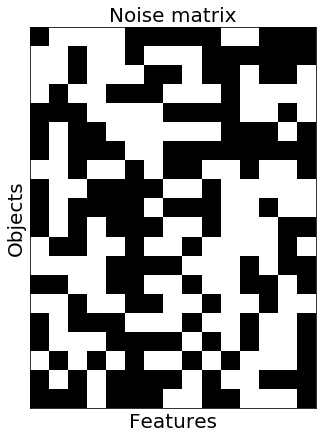

In [112]:
plt.figure(figsize = (10,7))
plt.imshow(sigma_mat[:20], cmap = 'Greys')
plt.xticks([])
plt.yticks([])
plt.ylabel('Objects', fontsize = 20)
plt.xlabel('Features', fontsize = 20)
plt.title('Noise matrix', fontsize = 20)
#cb = plt.colorbar()
#cb.set_label('Noise', fontsize = 20)
#cb.set_ticks([0.9])
#cb.set_ticklabels(['High'])
plt.show()

# Clean test set

In [124]:
#noise_in_features_vec =  [0.01, 1, 2, 6, 8, 10, 12]
noise_in_features_vec = [0.01, 1, 2.5, 5, 8, 10, 12.5, 15, 20]#[0.01, 1, 2.5, 5, 8, 10, 12, 14, 16, 18, 20, 25]#[0.01, 1, 10, 20, 30, 40, 50]

n_trees = 50
scores_RF = [] 
scores_PRF = [] 
scores_PRF_test_only = [] 
scores_PRF_train_only = [] 

for noise_in_features in noise_in_features_vec:
    noise_in_labels = 0
    X_tr, dX_tr, y_tr, pY_tr, fgo  = load_data.get_noised_data(X[obj_inds_train], 
                                                             dX_orig[obj_inds_train], 
                                                             y[obj_inds_train], 
                                                             sigma_mat[obj_inds_train], 
                                                             noise_in_labels, 
                                                             noise_in_features,
                                                             dist = 'normal')

    X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                             dX_orig[obj_inds_test], 
                                                             y[obj_inds_test], 
                                                             sigma_mat[obj_inds_test], 
                                                             0, 
                                                             0,
                                                             dist = 'normal')

    prf = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
    predict, proba = prf.predict(X=X_te, dX=dX_te)
    scores_PRF += [(predict == y_te).sum()/len(predict)]
    
    prf_test_only = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf_test_only.fit(X= X_tr,  y= y_tr, dX= numpy.zeros(dX_tr.shape), py= pY_tr)
    predict, proba = prf_test_only.predict(X=X_te, dX=dX_te)
    scores_PRF_test_only += [(predict == y_te).sum()/len(predict)]
    
    prf_train_only = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf_train_only.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
    predict, proba = prf_train_only.predict(X=X_te, dX=numpy.zeros(dX_te.shape))
    scores_PRF_train_only += [(predict == y_te).sum()/len(predict)]


    rf_sklean = sklearn.ensemble.RandomForestClassifier(n_estimators=n_trees, max_features=n_features, n_jobs = -1)
    rf_sklean.fit(X_tr, y_tr)
    score_RF = rf_sklean.score(X_te, y_te)
    scores_RF += [score_RF]
    print('Noise', noise_in_features, 
          'RF', scores_RF[-1], 
          'PRF', scores_PRF[-1], 
          'PRF_TEST_ONLY',  scores_PRF_test_only[-1],
          'PRF_TRAIN_ONLY',  scores_PRF_train_only[-1] )

Noise 0.01 RF 0.9672 PRF 0.959 PRF_TEST_ONLY 0.962 PRF_TRAIN_ONLY 0.9648
Noise 1 RF 0.9508 PRF 0.9534 PRF_TEST_ONLY 0.95 PRF_TRAIN_ONLY 0.9498
Noise 2.5 RF 0.9232 PRF 0.9314 PRF_TEST_ONLY 0.9216 PRF_TRAIN_ONLY 0.9316
Noise 5 RF 0.9034 PRF 0.9096 PRF_TEST_ONLY 0.8986 PRF_TRAIN_ONLY 0.9118
Noise 8 RF 0.8848 PRF 0.8932 PRF_TEST_ONLY 0.8788 PRF_TRAIN_ONLY 0.8986
Noise 10 RF 0.8822 PRF 0.8966 PRF_TEST_ONLY 0.878 PRF_TRAIN_ONLY 0.8982
Noise 12.5 RF 0.875 PRF 0.8884 PRF_TEST_ONLY 0.8788 PRF_TRAIN_ONLY 0.8906
Noise 15 RF 0.8784 PRF 0.8908 PRF_TEST_ONLY 0.8726 PRF_TRAIN_ONLY 0.8874
Noise 20 RF 0.8712 PRF 0.8866 PRF_TEST_ONLY 0.8682 PRF_TRAIN_ONLY 0.8928


# Clean train set

In [125]:
#noise_in_features_vec =  [0.01, 1, 2, 6, 8, 10, 12]
noise_in_features_vec = [0.01, 1, 2.5, 5, 8, 10, 12.5, 15, 20]#[0.01, 1, 2.5, 5, 8, 10, 12, 14, 16, 18, 20, 25]#[0.01, 1, 10, 20, 30, 40, 50]

n_trees = 50
scores_RF = [] 
scores_PRF = [] 
scores_PRF_test_only = [] 
scores_PRF_train_only = [] 

for noise_in_features in noise_in_features_vec:
    noise_in_labels = 0
    X_tr, dX_tr, y_tr, pY_tr, fgo  = load_data.get_noised_data(X[obj_inds_train], 
                                                             dX_orig[obj_inds_train], 
                                                             y[obj_inds_train], 
                                                             sigma_mat[obj_inds_train], 
                                                             noise_in_labels, 
                                                             0,
                                                             dist = 'normal')

    X_te, dX_te, y_te, pY_te, _  = load_data.get_noised_data(X[obj_inds_test], 
                                                             dX_orig[obj_inds_test], 
                                                             y[obj_inds_test], 
                                                             sigma_mat[obj_inds_test], 
                                                             0, 
                                                             noise_in_features,
                                                             dist = 'normal')

    prf = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
    predict, proba = prf.predict(X=X_te, dX=dX_te)
    scores_PRF += [(predict == y_te).sum()/len(predict)]
    
    prf_test_only = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf_test_only.fit(X= X_tr,  y= y_tr, dX= numpy.zeros(dX_tr.shape), py= pY_tr)
    predict, proba = prf_test_only.predict(X=X_te, dX=dX_te)
    scores_PRF_test_only += [(predict == y_te).sum()/len(predict)]
    
    prf_train_only = PRF.RandomForestClassifier(n_estimators=n_trees, max_features=n_features,
                                                        use_py_gini=True, use_py_leafs=True)
    prf_train_only.fit(X= X_tr,  y= y_tr, dX= dX_tr, py= pY_tr)
    predict, proba = prf_train_only.predict(X=X_te, dX=numpy.zeros(dX_te.shape))
    scores_PRF_train_only += [(predict == y_te).sum()/len(predict)]


    rf_sklean = sklearn.ensemble.RandomForestClassifier(n_estimators=n_trees, max_features=n_features, n_jobs = -1)
    rf_sklean.fit(X_tr, y_tr)
    score_RF = rf_sklean.score(X_te, y_te)
    scores_RF += [score_RF]
    print('Noise', noise_in_features, 
          'RF', scores_RF[-1], 
          'PRF', scores_PRF[-1], 
          'PRF_TEST_ONLY',  scores_PRF_test_only[-1],
          'PRF_TRAIN_ONLY',  scores_PRF_train_only[-1] )

Noise 0.01 RF 0.967 PRF 0.9594 PRF_TEST_ONLY 0.961 PRF_TRAIN_ONLY 0.962
Noise 1 RF 0.9312 PRF 0.9324 PRF_TEST_ONLY 0.9316 PRF_TRAIN_ONLY 0.9268
Noise 2.5 RF 0.8174 PRF 0.843 PRF_TEST_ONLY 0.8434 PRF_TRAIN_ONLY 0.8206
Noise 5 RF 0.7242 PRF 0.7736 PRF_TEST_ONLY 0.7726 PRF_TRAIN_ONLY 0.7458
Noise 8 RF 0.677 PRF 0.7402 PRF_TEST_ONLY 0.7318 PRF_TRAIN_ONLY 0.6858
Noise 10 RF 0.6748 PRF 0.7294 PRF_TEST_ONLY 0.7312 PRF_TRAIN_ONLY 0.6888
Noise 12.5 RF 0.6616 PRF 0.7232 PRF_TEST_ONLY 0.7192 PRF_TRAIN_ONLY 0.6732
Noise 15 RF 0.641 PRF 0.6984 PRF_TEST_ONLY 0.7072 PRF_TRAIN_ONLY 0.6588
Noise 20 RF 0.6338 PRF 0.703 PRF_TEST_ONLY 0.698 PRF_TRAIN_ONLY 0.6476
